In [1]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import numpy as np
from sklearn.metrics import f1_score,classification_report, confusion_matrix,precision_score, recall_score
from tensorflow import keras

In [2]:
#post data
df = pd.read_csv('processed_data/labled_data.csv',usecols=['post','compulsion','obs-com','obsession'])
df.head()

,compulsion,obs-com,obsession,enriched_post
0,0,0,1,Hi -\nSo I haven't been on here since December...
1,1,1,1,"Hi all, {Hoffnung} hope {espoir} {hope} you're..."
2,0,0,1,"Hi, \nFirst, I {Hoffnung} hope {espoir} {hope}..."
3,0,0,1,Hello everyone. I could really use your help r...
4,1,1,1,"Though it comes in many flavors, one of the mo..."


# **Data Preparation**

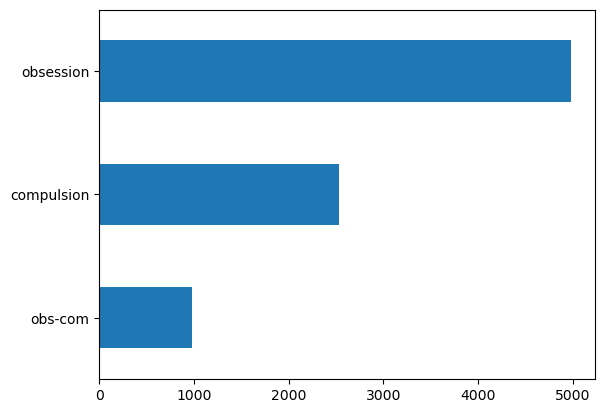

In [3]:
#print the number of post in each ensemble for each class(test data)
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [4]:
import re
#define the process of text cleaning
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',text)
#Clean Text
def clean_text(data):
    # convert catacter to lowercase
    data['clean_text']=data['post'].str.lower()
    #remove URLS
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"http\S+", "", elem))
    #remove ponctuation
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
    #remove
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'/n',"",elem))
    #remove degits
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\d+',"",elem))
    #remove emojis
    data['clean_text'] = data['clean_text'].apply(lambda elem:deEmojify(elem))
    #remove multiple spaces
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+'," ",elem))
    #remove single caracter
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))
    return data

In [5]:
#apply the process of cleaning for the train and test data
df = clean_text(df)

In [6]:
#for the text pre-processing (text cleaning)
import nltk
nltk.download('punkt')
import re #regular expression
import string
from nltk.tokenize import word_tokenize # word tokenization
from nltk.stem import PorterStemmer # word stemming

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def remove_stop_words(text):
  stopW=stopwords.words('english')
  s=""
  for i in text.split():
    if i not in stopW:
        s=s+i+" "
  return s

In [9]:
df['clean_text']=df['clean_text'].apply(lambda x:remove_stop_words(x))

In [10]:
def stem(ch):
  stem = PorterStemmer()
  return " ".join([stem.stem(i) for i in ch.split()])

#apply the stem function to each row in the dataframe
df['clean_text'] = df['clean_text'].apply(lambda x:stem(x))

In [11]:
X, Y = df['clean_text'], df[['compulsion','obsession']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5235,), (5235, 2), (1309,), (1309, 2))

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
num_words = 2000
vect=Tokenizer(num_words=num_words)
vect.fit_on_texts(X_train)
vocab_size = len(vect.word_index) + 1
print(vocab_size)

20555


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoded_docs_train = vect.texts_to_sequences(X_train)
MAX_LEN = 150
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=MAX_LEN, padding='pre')
padded_docs_train.shape

(5235, 150)

In [15]:
encoded_docs_test =  vect.texts_to_sequences(X_test)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=MAX_LEN, padding='pre')

In [16]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [17]:
def get_model():
    model = Sequential()
    # Configuring the parameters
    model.add(Embedding(num_words, output_dim=16, input_length=MAX_LEN))
    model.add(LSTM(16, return_sequences=True))  
    # Adding a dropout layer
    model.add(Dropout(0.5))
    model.add(LSTM(8))
    # model.add(Dropout(0.5))
    model.add(Dense(4))
    # model.add(Dropout(0.5))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model

In [18]:
compulsion_model = get_model()
y_compulsion_train = y_train.values[..., :1]
compulsion_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
compulsion_history = compulsion_model.fit(padded_docs_train, y_compulsion_train, epochs=1000, batch_size=16,validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, min_delta=1e-7),
                              keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10),
                              keras.callbacks.ModelCheckpoint(filepath='model/lstm_compulsion_model.h5', 
                                      monitor='val_loss', 
                                      save_best_only=True)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 16)           32000     
                                                                 
 lstm (LSTM)                 (None, 150, 16)           2112      
                                                                 
 dropout (Dropout)           (None, 150, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 34,953
Trainable params: 34,953
Non-traina

In [19]:
compulsion_model.load_weights('model/lstm_compulsion_model.h5')
compulsion_predictions = compulsion_model.predict([padded_docs_test])

41/41 [==============================] - 1s 10ms/step


In [20]:
print('Compulsion Prediction Result')
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=compulsion_predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test.values[:, :1], pred, average='micro')
    recall = recall_score(y_test.values[:, :1], pred, average='micro')
    f1 = f1_score(y_test.values[:, :1], pred, average='micro')
   
    print("Micro-average quality numbers for threshold", val)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Compulsion Prediction Result
Micro-average quality numbers for threshold 0.1
Precision: 0.9030, Recall: 0.9030, F1-measure: 0.9030
Micro-average quality numbers for threshold 0.2
Precision: 0.9221, Recall: 0.9221, F1-measure: 0.9221
Micro-average quality numbers for threshold 0.3
Precision: 0.9335, Recall: 0.9335, F1-measure: 0.9335
Micro-average quality numbers for threshold 0.4
Precision: 0.9381, Recall: 0.9381, F1-measure: 0.9381
Micro-average quality numbers for threshold 0.5
Precision: 0.9381, Recall: 0.9381, F1-measure: 0.9381
Micro-average quality numbers for threshold 0.6
Precision: 0.9374, Recall: 0.9374, F1-measure: 0.9374
Micro-average quality numbers for threshold 0.7
Precision: 0.9396, Recall: 0.9396, F1-measure: 0.9396
Micro-average quality numbers for threshold 0.8
Precision: 0.9404, Recall: 0.9404, F1-measure: 0.9404
Micro-average quality numbers for threshold 0.9
Precision: 0.9381, Recall: 0.9381, F1-measure: 0.9381


In [21]:
Y_test = y_test.copy()
Y_test['compulsion_pred'] = compulsion_predictions

In [22]:
Y_test[:40]

,compulsion,obsession,compulsion_pred
1277,1,1,0.927803
4982,1,1,0.927404
1022,0,1,0.025737
5835,0,1,0.024257
1675,0,1,0.022814
2137,1,0,0.914856
48,1,1,0.930740
751,0,1,0.022701
1106,1,0,0.023212
3680,1,0,0.927750


In [23]:
import pickle
with open('model/lstm_tockenizer_compulsion.pkl', 'wb') as f:
    pickle.dump(vect, f)